## Load data

In [2]:
%load_ext autoreload
%autoreload

import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from data_utils import get_training, get_testing, HEADER
from sklearn.linear_model import LogisticRegression

from validation import Validation
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from my_pca import my_pca

%matplotlib notebook

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## LinearDiscriminantAnalysis

In [11]:
# Logistic Regression
X, y = get_training()
mdl = LogisticRegression()
val = Validation(X, y, k = 10)

pca_comp = [3,5,9,11,13,15,20,25,30]

pca_results = {
    'accuracy' : [],
    'recall' : [],
    'precision' : []
}

bsf = (0,-1,-1)

for comp in pca_comp:
    val.update(pca=comp)
    acc = val.cross_val_accuracy(mdl)
    r = val.get_detailed_results()
    pca_results['accuracy'].append(np.array(r['accuracy']).mean())
    pca_results['recall'].append(np.array(r['recall']).mean())
    pca_results['precision'].append(np.array(r['precision']).mean())
    
    if bsf[0] < acc:
        bsf = (acc, comp)
        
best_pca_comp = bsf[1]

In [13]:
# Logistic Regression
X, y = get_training()
mdl = LogisticRegression()
val = Validation(X, y, k = 10, pca=best_pca_comp)

models = [('L2, C=1', LogisticRegression()),
          ('L2, C=10', LogisticRegression(C=10)),
          ('L2, C=100', LogisticRegression(C=100)),
          ('L1, C=1', LogisticRegression(penalty='l1')),
          ('L1, C=5', LogisticRegression(penalty='l1', C=5)),
          ('L1, C=10', LogisticRegression(penalty='l1', C=10))]

c_results = {
    'accuracy' : [],
    'recall' : [],
    'precision' : []
}

for description, mdl in models:
    acc = val.cross_val_accuracy(mdl)
    r = val.get_detailed_results()
    c_results['accuracy'].append(np.array(r['accuracy']).mean())
    c_results['recall'].append(np.array(r['recall']).mean())
    c_results['precision'].append(np.array(r['precision']).mean())
    if bsf[0] < acc:
        bsf = (acc, best_pca_comp, description)

In [30]:
print best_pca_comp
print description
mdl = LogisticRegression(penalty='l1', C=10)
print bsf[0]

30
L1, C=10
0.983340425532


## Plot Scores

<IPython.core.display.Javascript object>


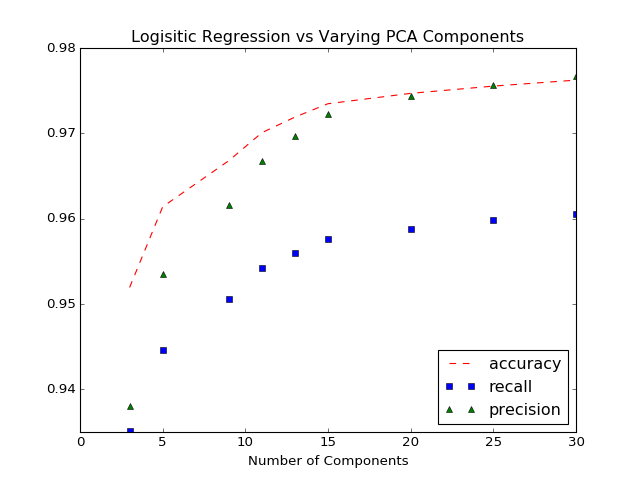

In [24]:
plt.close()
lines = plt.plot(pca_comp, pca_results['accuracy'], 'r--', pca_comp, pca_results['recall'], 'bs', pca_comp, pca_results['precision'], 'g^')
plt.legend(lines, ('accuracy','recall','precision'),loc='lower right')
plt.title('Logisitic Regression vs Varying PCA Components')
plt.xlabel('Number of Components')
plt.show()

<IPython.core.display.Javascript object>


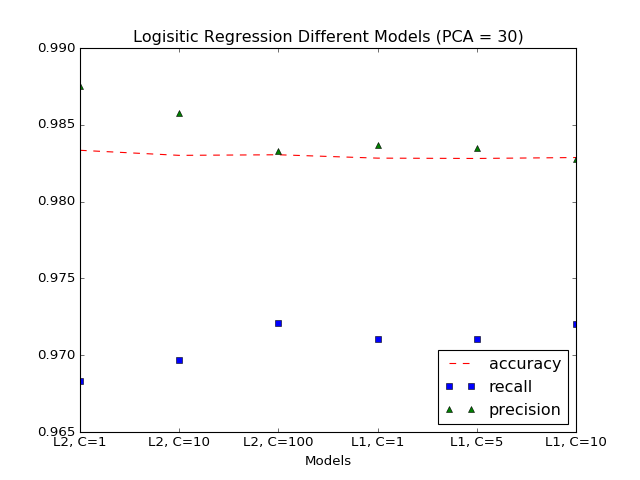

In [25]:
plt.close()
descriptions = [d for d,m in models]
x=range(1, len(c_results['accuracy']) + 1)
lines = plt.plot(x, c_results['accuracy'], 'r--', x, c_results['recall'], 'bs', x, c_results['precision'], 'g^')
plt.legend(lines, ('accuracy','recall','precision'),loc='lower right')
plt.title('Logisitic Regression Different Models (PCA = 30)')
plt.xlabel('Models')
plt.xticks(x,descriptions)
plt.show()

## Confusion matrices

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '%.2f'%cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.gcf().subplots_adjust(bottom=0.2)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<IPython.core.display.Javascript object>


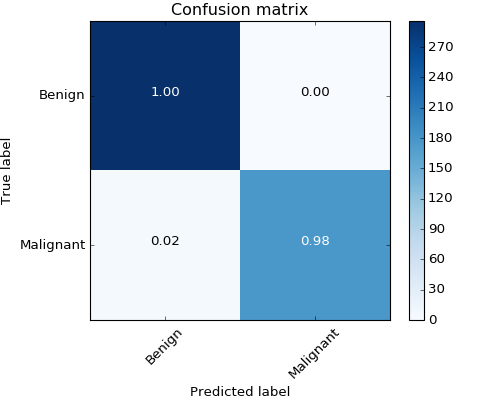

Normalized confusion matrix


In [29]:
mdl = LogisticRegression(penalty='l1', C=10)
plt.figure(figsize=(6,5))
X_reduced = my_pca(X,best_pca_comp)
y_pred = mdl.fit(X_reduced, y).predict(X_reduced)
cm_pca = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm_pca, classes=['Benign', 'Malignant'], normalize=True)
